# Automated Discovery of Temperature Dependent Structural Change

    Neutron powder diffraction is a powerful way to examine the atomic structure of technologically interesting materials. The particular material from this data set is a candidate for solar cells . Nevertheless, the same methods are used in battery materials, catalysts, etc. A single data set has 2 dimensions: Intensity(I) and d spacing (d). The d spacing is a characteristic structural scale in the system. If there is a large I at a given d, that means there are at least two atoms spaced at that distance in the system. If I is at the background it means there is nothing with that d spacing in the material.
    
    Often functional behavior is related to a structural change with an external parameter like temperature. This structural change show up as change in the existence, position or width of the peaks. The provided data set is a collection of I vs d curves at multiple temperatures. So the data set is 3 dimensional I(d,T). The data is in an HDF5 file. H5py is a useful set of libraries for accessing HDF5 files from python. If you are not familiar with hdf5 and want to browse the data structure want to browse the data structure we recommend hdfview or nexpy. However, the developed algorithms should run independently of these codes.

# Challenge
    Given the aforementioned data set, here are the challenge questions
    
    1. Provide an algorithm that given the data set as an input, provides the temperature of the structural transition.
    2. Provide an algorithm that gives the integrated area under, the center of intensity, and a characteristic width for the peak that is between 3.2 and 3.3 Å in d spacing as a function of temperature.
    3. Provide an algorithm that gives the integrated area under, the center of intensity, and a characteristic width for all peaks at a given Temperature.
    4. Given adjacent temperatures, provide an algorithm that indicates if a phase transition occurred between the two temperatures, a list of centers, widths, and intensities for all peaks in the data set that are at least 1.5x above background in under 5 seconds

    Our preference is for the algorithms to be implemented in Python with use of the numpy library, other necessary libraries are welcome. If the participant prefers a compiled code, C/C++, is our preferred solution with the output being in a python or numpy data structure.

In [1]:
import numpy as np
import scipy as sp

#import h5py
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 300
#%matplotlib notebook
%matplotlib inline

from nexusformat.nexus import *
import warnings
warnings.filterwarnings('ignore')

from IPython.core.pylabtools import figsize
np.set_printoptions(precision=3)

from matplotlib import rc
rc('text', usetex=True)
mpl.rcParams['savefig.dpi'] = 300

import os
os.makedirs('Q3/Data/', exist_ok=True)
os.makedirs('Q3/Figs/', exist_ok=True)

# Q0. Load the data and convert the data into np arrays. 

In [2]:
ff = nxload('NPD_Temp.nxs')
data = ff.entry.data

'''convert to numpy array'''
intsy = np.asarray(data['intensity'])
QQs = np.asarray(data['Q'])
dds = np.asarray(data['dspacing'])
temps = np.asarray(data['temperature'])
dd_cs = (dds[:-1]+dds[1:])/2
temp_cs = (temps[:-1]+ temps[1:])/2

# Q3 Provide an algorithm that gives the integrated area under, the center of intensity, and a characteristic width for all peaks at a given Temperature.

    


##    3.1  Same as what we have done for Q0, using DB scan to find global background and then remove the background.

    This will reduce the number of parameters needed for peak fitting. 

In [19]:
from sklearn.cluster import DBSCAN

def Plot_Clustering(db, signal, dd_cs, pars, savefilename=""):
    '''
    plot the results of DBScan:
        signal = -1, plot background point
        signal = others, plot signal point
    '''
    if signal == -1:
        _xx, _yy = pnt_loc[db.labels_ == -1].T
        title = 'Bkg points by DBSCAN.'
    else:
        _xx, _yy = pnt_loc[db.labels_ != -1].T
        title = 'Signal above background found by DBSCAN.'

    _xx = dd_cs[(_xx/s).astype(int)]
    _yy = pars[(_yy).astype(int)]
    
    plt.figure()
    plt.plot(_xx, _yy, '.', markerfacecolor='blue',
                 markeredgecolor='none', markersize=1)
    plt.xlabel('d-spacing(\AA)')
    plt.ylabel('temperature (K)')
    xlims = [_xx.min(), _xx.max()]
    ylims = [_yy.min(), _yy.max()]
    plt.xlim(xlims)
    plt.ylim(ylims)
    plt.tight_layout()
    plt.title(title)
    if len(savefilename) > 0:
        plt.savefig(savefilename, dpi=600)
    plt.show()    
    return 

def fit_Global_Bkg(Coef, Intsy, pars, bin_cs, Par_Order=1, Bin_Order =1):
    '''
    A fitting functino for the background of a 2D data.
    bkg = C0 + C1 * pars + C2 * pars^2 + ... + C(Par_Order+1) * bins_center+ ...
    '''
    if len(Coef) != (1 + Par_Order + Bin_Order):
        raise ValueError("Dimension mismatch on number of Coef.") 
    
    npts = len(Intsy)
    if npts != len(pars):
        print('npts = %d, bin_cs = %d' %(npts,len(bin_cs)))
        raise ValueError("Dimension mismatch on number of experimental parameters.")  
        
    if npts != len(bin_cs):
        print('npts = %d, bin_cs = %d' %(npts,len(bin_cs)))
        raise ValueError("Dimension mismatch on number of bins.")  
        
    model = np.empty(npts)
    model.fill(Coef[0])
    _pars, _bins = pars.copy(), bin_cs.copy()
    
    jj = 1
    for ii in range(Par_Order): 
        model += Coef[jj] * _pars
        jj += 1
        if(ii+1 < Par_Order):
            _pars *= pars
    
    for ii in range(Bin_Order): 
        model += Coef[jj] * _bins
        jj +=1
        if(ii+1 < Bin_Order):
            _bins *=bin_cs
    
    diffs = model  - Intsy 
   
    return diffs.flatten() # it expects a 1D array out. 


def rm_Global_Bkg(Coef, IntsyMap, pars, bin_cs, Par_Order=1, Bin_Order =1):
    '''
    A fitting functino for the background of a 2D data.
    bkg = C0 + C1 * pars + C2 * pars^2 + ... + C(Par_Order+1) * bins_center+ ...
    '''
    
    npars, nbins = IntsyMap.shape
    
    if len(Coef) != (1 + Par_Order + Bin_Order):
        raise ValueError("Dimension mismatch on number of Coef.") 
    
    if npars != len(pars):
        raise ValueError("Dimension mismatch on number of experimental parameters.")  
        
    if nbins != len(bin_cs):
        raise ValueError("Dimension mismatch on number of bins.")  
        
    signal = IntsyMap - Coef[0]
    
    yy, xx = np.meshgrid(bin_cs, pars)
    _xx, _yy = xx.copy(), yy.copy()
    
    jj = 1
    for ii in range(Par_Order): 
        signal -= Coef[jj] * _xx
        jj += 1
        if(ii+1 < Par_Order):
            _xx *= xx
    
    for ii in range(Bin_Order): 
        signal -= Coef[jj] * _yy
        jj +=1
        if(ii+1 < Bin_Order):
            _yy *= yy
 
    return signal 

def Opt_Globkg_order(Intsy, pars, bin_cs, tol= 1e-3, 
                     Par_maxOrder=2, Bin_maxOrder=2):
    '''
    test how the background fitting depends on the order of fitting parameters. 
        test up to npars order on pars,  and ndds order on bins
        
    auto-select the optimzed results using the relative tolerance. 
    '''
    from scipy.optimize import leastsq
    from numpy.linalg import norm
    
    bkg0 = Intsy.mean()
    
    bkg_ini = [Intsy.mean()]
    bkg_coef = leastsq(fit_Global_Bkg, bkg_ini, 
                                     args = (Intsy, pars, bin_cs, 0, 0))
    fit = fit_Global_Bkg(bkg_coef[0], Intsy, pars, bin_cs, 0, 0)
    Chi2_0 = norm(fit)
    for ii in range(1, Par_maxOrder+1):
        bkg_ini.append(0)
        bkg_coef = leastsq(fit_Global_Bkg, bkg_ini, 
                                     args = (Intsy, pars, bin_cs, ii, 0))
        fit = fit_Global_Bkg(bkg_coef[0], Intsy, pars, bin_cs, ii, 0)
        Chi2_1 = norm(fit)
        delta = Chi2_0/Chi2_1 - 1
        Chi2_0 = Chi2_1
        if delta < tol:
            break
            
    for jj in range(1, Bin_maxOrder+1):
        bkg_ini.append(0)
        bkg_coef = leastsq(fit_Global_Bkg, bkg_ini, 
                                     args = (Intsy, pars, bin_cs, ii, jj))
        fit = fit_Global_Bkg(bkg_coef[0], Intsy, pars, bin_cs, ii, jj)
        Chi2_1 = norm(fit)
        delta = Chi2_0/Chi2_1 - 1
        Chi2_0 = Chi2_1
        if delta < tol:
            break
    
    print("Par_order = %d, Bin_Order = %d" %(ii, jj))
    
    return bkg_coef[0], ii, jj

### 3.1.1 Estimate the background level and removing the backgound. 

In [4]:
s = 0.33
binindex = np.arange(len(dd_cs)) * s
tempindex = np.arange(len(temps))
xx, yy = np.meshgrid(binindex, tempindex)
pnt_loc = np.vstack((xx.flatten(), yy.flatten())).T

pnt_weight = intsy.flatten()
bkg_val = np.percentile(pnt_weight, 50)
print('rough estimateion of background level ', bkg_val)
bkg = pnt_weight[pnt_weight < bkg_val]

# using eps = 1.1 to including 13 neighbors.
n_cutoff = np.round(13 * (bkg_val + bkg.std() * 2))
db = DBSCAN(eps=1.1, min_samples=n_cutoff, n_jobs=-1).fit(pnt_loc, sample_weight = pnt_weight)
print("number of cutoff %5.2e; number ofclusters, %d, including bkg" %(n_cutoff, len(set(db.labels_))))

#plt.figure(figsize(12, 4.8))
#Plot_Clustering(db, -1, dd_cs, temps, savefilename="Q3/Figs/BKG_pnts_DBSCAN.png")
#Plot_Clustering(db, 0, dd_cs, temps, savefilename="Q3/Figs/Signal_pnts_DBSCAN.png")

_xx, _yy = pnt_loc[db.labels_ == -1].T
_xx = dd_cs[(_xx/s).astype(int)]
_yy = temps[(_yy).astype(int)]
_bkg = pnt_weight[db.labels_ == -1]
Bkg_Coef, _Pars, _Bins = Opt_Globkg_order(_bkg, _yy, _xx, tol=1e-3, 
                                            Par_maxOrder=5, Bin_maxOrder=5)
print(Bkg_Coef, _Pars, _Bins)
intsy_rmbkg = rm_Global_Bkg(Bkg_Coef, intsy, temps, dd_cs, _Pars, _Bins)
np.save('Q3/Data/intsy_rmbkg', intsy_rmbkg)

rough estimateion of background level  91.8044717908
number of cutoff 1.80e+03; number ofclusters, 130, including bkg
Par_order = 2, Bin_Order = 3
[  9.926e+01   1.312e-01  -1.964e-04  -1.292e+01   1.148e+00  -1.857e-02] 2 3


## 3.2 Find peaks via wavelet transformation. 
    
    scipy.signal.find_peaks_cwt(vector, widths, wavelet=None, max_distances=None, gap_thresh=None, min_length=None, min_snr=1, noise_perc=10)
   
    The algorithm is as follows:
    Perform a continuous wavelet transform on vector, for the supplied widths. This is a convolution of vector with wavelet(width) for each width in widths. See cwt
    Identify “ridge lines” in the cwt matrix. These are relative maxima at each row, connected across adjacent rows. See identify_ridge_lines
    Filter the ridge_lines using filter_ridge_lines.
    

In [5]:
from scipy.signal import find_peaks_cwt 

def plot_peakloc(intsymap, pars, bin_cs, peakloc, par_val=0, outputfilename = ""):
    '''
    plot the peak location figure.  
    '''
    import numpy as np
    
    # set up the figure properties
    rc('text', usetex=True)
    
    parindx = (abs(pars-par_val)).argmin()
    data = intsymap[parindx]
    # for plotting purpose
    data[data<0] = 0
    data_sqrt = data**0.5
    ylims = data_sqrt.max()
    
    plt.semilogx(bin_cs, data_sqrt, '.-', markersize=2, lw=1)
    npeaks = len(peakloc)
    plt.semilogx(peakloc, np.full(npeaks, -2), '|', mfc=None, mec='r', mew=2, ms=8,
                    label='%d peaks' % (len(peakloc)))

    plt.ylim(-ylims*0.1, ylims*1.2)
    title_ = 'T = %5.2f K' % (pars[parindx])
    plt.title(title_)
    plt.xlabel('d spacing (\AA)')
    plt.ylabel('\sqrt{Intensity}')
    plt.legend()
    plt.tight_layout()
    if len(outputfilename) > 0:
        plt.savefig(outputfilename)
    
    return

def plot_peakloc_indx(intsymap, pars, bin_cs, peakind, par_val=0, outputfilename = ""):
    '''plot the peak location figure from the peak index array.'''
    peakloc = bin_cs[peakind]
    plot_peakloc(intsymap, pars, bin_cs, peakloc, par_val, outputfilename)
    return   

### 3.2.1 Using ricker wavelet and  a full d range data at a single temperature.

    1. Data at low-d and high-d have very different noise lelve, causing poor performance using a single criterion for peak finding in the full d-range. 
    2. Tried to use Savgol fucntion to smooth the data. It helps little.

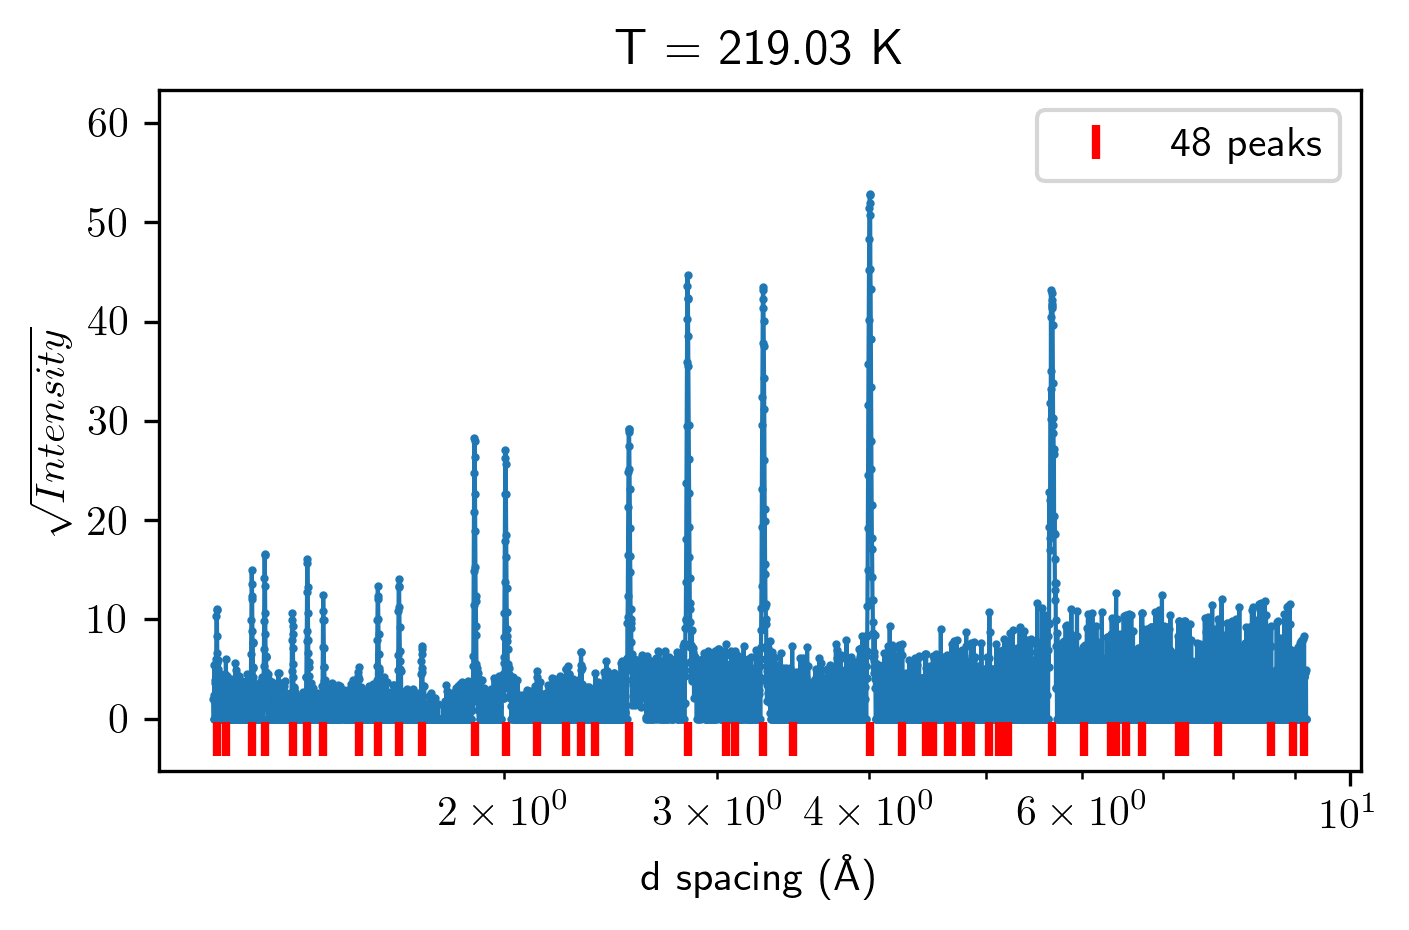

In [6]:
temp = 220
data = intsy[(abs(temps-temp)).argmin()].flatten()

wws = np.arange(3, 16)
minlength = round(wws.size /4)
wws, wws.size, minlength
SNr = 1.5
peakind = find_peaks_cwt(data, wws, min_snr=SNr, 
                         min_length=minlength, noise_perc=10)

figsize(4.8, 3.2)
filename = "Q3/Figs/peakfinding_ricker_%dK.png" %temp
plot_peakloc_indx(intsy_rmbkg, temps, dd_cs, peakind, par_val=temp, 
                  outputfilename = filename)

### 3.2.2 Considering the characteristics of the TOF PWD data. 
   
   1. Asymmetric diffraction peak profile ==> Designing a asymmetric ricker wavelet
   2. Noise levels are different for high-d and low-d data ==> using different criteria for peak finding. 

In [31]:
from numba import jit

@jit
def _ricker_asy(points, a):
    """
    A modified ricker wavelet based on the powder diffraction peak shape. 
    """
    alpha = 0.8
    
    A = 0.5 / (a  * (np.pi**0.5))
    wsq = a**2
    
    vec = np.arange(0, points) - (points - 1.0) / 2
    vec[np.int(points/2):] *=-alpha
    xsq = vec**2
    vec_oa = vec/a 
    
    mod = (1 - xsq / wsq)
    gauss = np.exp(-xsq / (2 * wsq))
    total = A * mod * gauss
    return total

def _find_peaks_byindx(data, sep = 1/4., min_dis=2, wavelet=_ricker_asy):
    '''
        a new version of find_peaks(). only deal a single dataset as the input.
        1. cut the data into two segements. [0, sep] and [sep, 1]
        2. find peak in each segement and merge the peak together.
        
        3. combined peaks if their distance is less than a min_distance
        '''
    from scipy.signal import find_peaks_cwt 
    import numpy as np

    if sep < 0 or sep > 1:
        raise ValueError("seperation value should be in (0, 1]")
        
    nbins = data.size
    bin_cutoff = int(sep * nbins)
    bin_0, bin_1 = int(bin_cutoff * 1.02), int(bin_cutoff * 0.98)
    data_0, data_1 = data[:bin_0], data[bin_1:]
    
    wws = np.arange(2, 9.0, 1)
    minlength = 3
    SNr = 1.5
    peakind_0 = find_peaks_cwt(data_0, wws, wavelet=wavelet, 
                            min_length = minlength, min_snr=SNr, noise_perc=10)
    
    if len(peakind_0) > 0:
        peakind_0 = peakind_0[:-1] if peakind_0[-1] > bin_cutoff else peakind_0
    
    if sep < 1 :
        wws = np.arange(3, 14, 1.5)
        minlength = 3
        SNr = 2.5
        peakind_1 = find_peaks_cwt(data_1, wws, wavelet=wavelet, 
                                min_length = minlength, min_snr=SNr, noise_perc=10)
        # updated to the original bin index
        peakind_1 += bin_1
        peakind_1 = peakind_1[1:] if peakind_1[0] < bin_cutoff else peakind_1

        peakind = np.sort(np.concatenate((peakind_0,peakind_1),0))
    else:
        peakind = peakind_0
    
    peakind = _peak_cleanup_by_distance(peakind, min_dis)
    
    return peakind


@jit 
def _peak_cleanup_by_distance(peakindx, min_dis, lens=0):
    ''' 
    
    Define a quick way to remove one of the higher-indexed (index: ii+1) peak if two adjacent 
    peaks are too close to each other,  unless the lower-indexed peak (ii) has been removed 
    and the distance between peaks ii+1 and ii-1 is more thatn min_dis. 
    No more iterations is checked beyond this. 
    There is an option to remove peaks too close to the edges, if lens is defined.
    --
    Input: 
        peak index array.
        minimum index distance.
    Output:
        A new peak index array
    '''
    
    if lens > 0:
        peakindx = peakindx[peakindx > min_dis]
        peakindx = peakindx[peakindx < (lens - min_dis)]
    
    npeaks = peakindx.size
    if npeaks > 0:
        unique_peak=[peakindx[0]]
    else:
        return np.asarray([])
    
    if npeaks > 1:
        dist = peakindx[1:] - peakindx[:-1]
        ii=0
        for ii in range(dist.size):
            if dist[ii] >= min_dis:
                unique_peak.append(peakindx[ii+1])
            elif ii>0 & (dist[ii]+dist[ii-1]) >= min_dis:
                unique_peak.append(peakindx[ii+1])

    
    return np.asarray(unique_peak)

In [33]:
temp = 220
indx = (abs(temps-temp)).argmin()
data = intsy[indx]

plt.plot()

NameError: name '_temps' is not defined

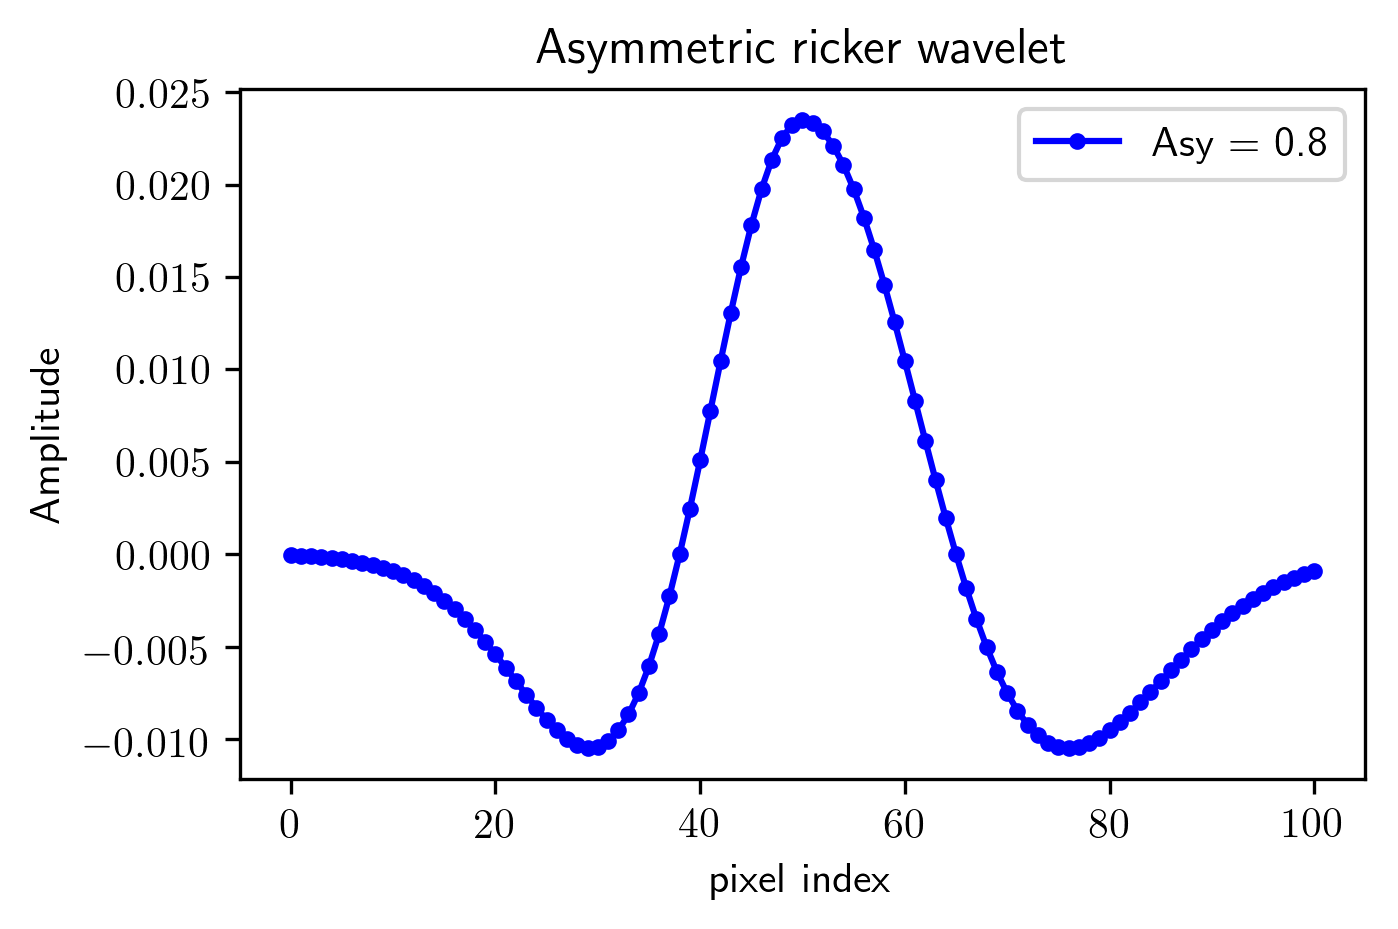

In [47]:
plt.figure(figsize(4.8, 3.2))
ricker_line = _ricker_asy(101, 12)
plt.plot(ricker_line, '.-', color='b',label="Asy = 0.8")
plt.title('Asymmetric ricker wavelet')
plt.xlabel('pixel index')
plt.ylabel('Amplitude')
#plt.ylim(-0.015, 0.03)
plt.legend(loc=1)
plt.tight_layout()
#plt.savefig('Q3/Figs/Asy_ricker_wavelet')

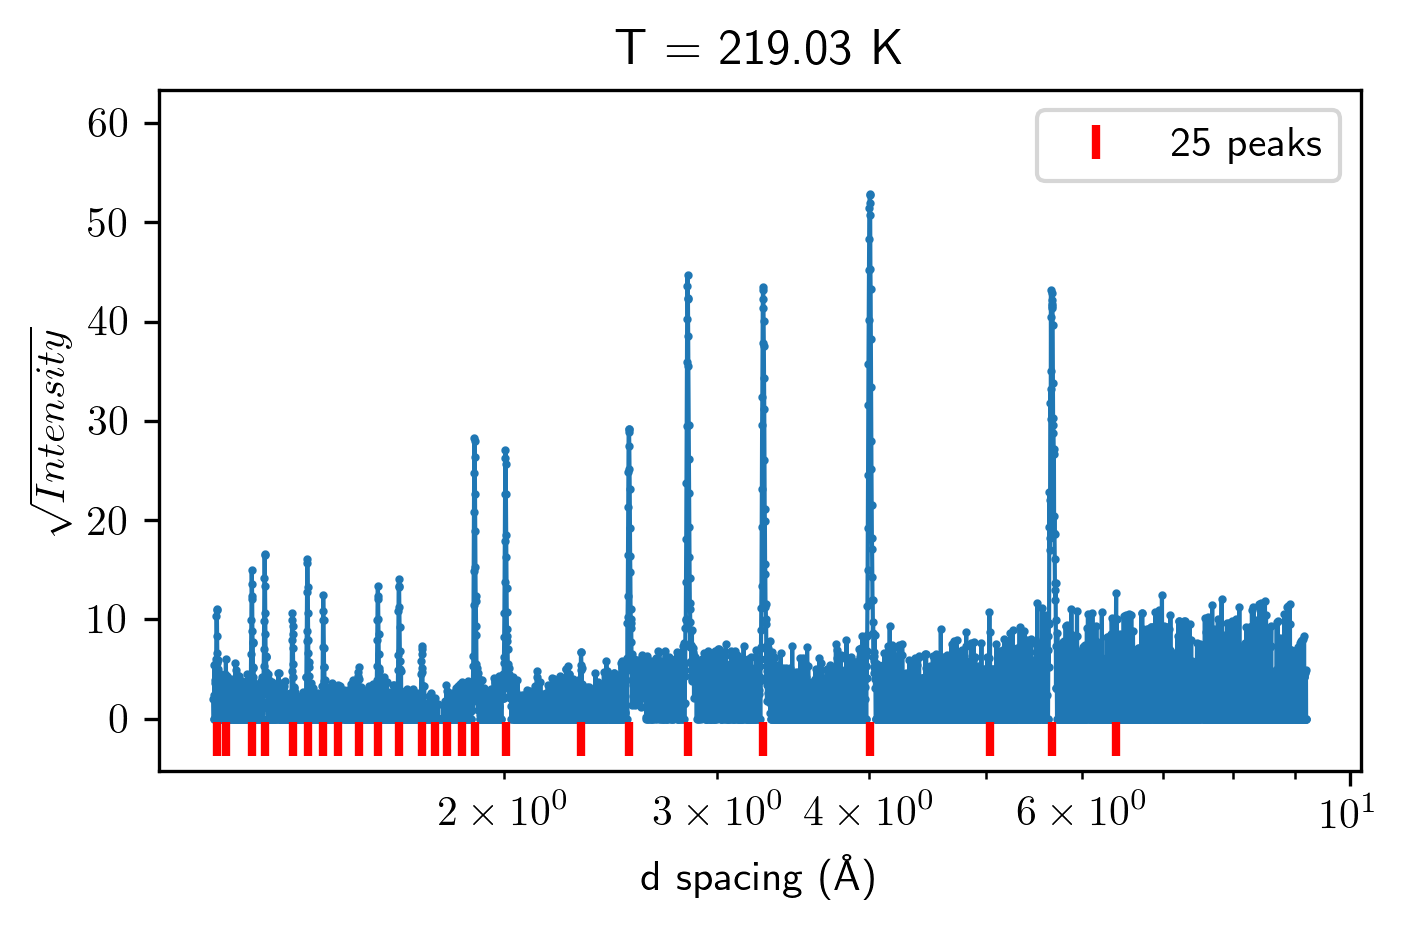

In [9]:
temp = 220
data = intsy_rmbkg[(abs(temps-temp)).argmin()]
peakind = _find_peaks_byindx(data)
filename = "Q3/Figs/peakfinding_asyricker_%dK" %(temp)
plt.figure(figsize(4.8, 3.2))
plot_peakloc_indx(intsy_rmbkg, temps, dd_cs, peakind, 
                  par_val=temp, outputfilename = filename)

## 3.3 global fitting the peaks, removing the peaks whose amplitudes are lower than a cut-off threshold, saving the results. 

In [10]:
from numba import jit
from scipy.optimize import least_squares

@jit
def Ini_Mpeaks_pars(Intsy, peakind, bin_cs, Bkg=[70, 0], 
                    peakwidth_pars=[1e-3, 2e-4, 6e-4], dtol=1e-3):
    '''
    set up a fitting function including all peaks and a background term
        background: OrderofBkg + 1
            limits can be tuned by experience. [-10, 10] for non-zero order
        resolution: 3, peak_width = C0 + C1*d + C2*d^2, [0, 0.1^n]
        peak amplitude: npeaks, [0, inf]
        peak center : npeaks, [d_c*(1-dtol), d_c*(1+dtol)]
        
        jj: parameter index
    '''
    npeaks = peakind.size
    NoBkg = len(Bkg)
    nCoef = NoBkg + 3 + npeaks * 2 
    par_ini, low_lmt, high_lmt= np.zeros(nCoef), np.zeros(nCoef), np.zeros(nCoef)
    
    # background
    if NoBkg >0:
        par_ini[:NoBkg] = Bkg
        high_lmt[0] = Intsy.mean()
        if NoBkg > 1:
            low_lmt[1:NoBkg], high_lmt[1:NoBkg] = -10, 10
    
    # peak width, all peak width parameters are positively defined.  
    jj = NoBkg
    par_ini[jj:jj+3] =  peakwidth_pars
    high_lmt[jj:jj+3] = [4e-3, 2e-3, 1e-3]
    
    #peak amplitude, all peak width terms are positively defined.
    jj += 3
    maxbin = bin_cs.size
    for ii in range(0, npeaks):
        _centerbinindx = peakind[ii]
        _low, _high = max(0, _centerbinindx - 4), min(maxbin-1, _centerbinindx + 4)
        _data_max = Intsy[_low:_high].max()
        par_ini[jj]  = _data_max
        high_lmt[jj] = _data_max *1.2
        jj+=1
    
    #peak center
    peaks_ctr = bin_cs[peakind]
    par_ini[jj:jj+npeaks] = peaks_ctr[:]
    low_lmt[jj:jj+npeaks], high_lmt[jj:jj+npeaks] = peaks_ctr[:]*(1-dtol), peaks_ctr[:] * (1+dtol)
    
    bounds =tuple([low_lmt, high_lmt])
    return par_ini, bounds 

@jit
def Mpeaks_LS(Coef, Intsy, peakind, bin_cs, NoBkg=2):
    '''
    use with scipy.optimize.least_squares
    call Mpeaks_model_1d() to calculate the model results and 
    reutrn the difference between model and data
    '''
    model = Mpeaks_model(Coef, Intsy, peakind, bin_cs, NoBkg)
    mask = model > 0
    diff = model[mask]-Intsy[mask]
    
    return  diff # it expects a 1D array out. 

@jit
def Mpeaks_model(Coef, Intsy, peakind, bin_cs, NoBkg=2):
    '''
    set up a fitting function including all peaks and a background term
        1. background: OrderofBkg + 1
        2. resolution: 3, peak_width = C0 + C1*d + C2*d^2, [0, 0.1^n]
        3. peak amplitude: npeaks, [0, inf]
        4. peak center : npeaks, [d_c*(1-dtol), d_c*(1+dtol)]
    
    return the model results.
    '''
    npeaks = peakind.size
    npts = Intsy.size
    
    # model bkg, polynominal 
    jj = 0
    if NoBkg > 0:
        model = np.full(npts, np.float(Coef[0]))
        jj += 1
        if NoBkg > 1:
            bins_jj = bin_cs.copy() 
            for ii in range(1, NoBkg):
                model += Coef[ii] * bins_jj
                jj += 1
                if(ii+1 < NoBkg): bins_jj*= bin_cs
    else:
        model = np.full(npts, 0.)
        
    _C0, _C1, _C2 = Coef[jj:jj+3]  
    jj += 3
    
    # model peaks, each peak is of shape A0 * exp[ (xx -A1)**2 / A2
    # calcuate for region +/- 12 pixels, which is sufficent.
    # each peak needs extra two parameters
    max_indx = npts -1
    for ii in range(0, npeaks):
        # index range for peak ii
        _centerbinindx = peakind[ii]
        _low, _high = max(0, _centerbinindx - 12), min(max_indx, _centerbinindx + 12)
        #calculate the relative distance to peak center and define a single peak
        _peak_center = Coef[jj+npeaks]
        _sigma = _C0 + _C1 * _peak_center + _C2 * _peak_center**2
        _dd_offset_sq = ((bin_cs[_low:_high] - _peak_center)/_sigma)**2
        _peak = Coef[jj] * np.exp(-_dd_offset_sq)
        model[_low:_high] += _peak 
        jj += 1
    return  model # it expects a 1D array out. 

  
@jit
def gen_peaktable(fitpars, bin_cs, peakindx, NoBkg=2, cutoff = 0):
    '''
    generate the peaktable from global peak fitting results
    
    peaktable: peak_pos, peak_amplitude,  peak_width
    '''
    npars = len(fitpars) - NoBkg - 3
    npeaks = len(peakindx)
    if npars != npeaks *2:
        raise ValueError("Dimension mismatch between peak parameters and peaks.")
    
    jj = NoBkg+3
    _C0, _C1, _C2 = fitpars[NoBkg:jj]  
    
    peaktable = np.empty([npeaks, 4])
    # [0] pos , [1] amplitude, [2] width, and [3] area
    _pos = fitpars[jj+npeaks:]  # in d value
    _amp = fitpars[jj:jj+npeaks]
    _sigma = _C0 + _C1 * _pos + _C2 * (_pos**2)
    _binsize = bin_cs[1:] - bin_cs[:-1]
    _sigma_in_bin = _sigma / _binsize[peakindx] 
    _area = (2* np.pi)**0.5 * _amp * _sigma_in_bin
    
    peaktable[:, 0] = _pos
    peaktable[:, 1] = _amp
    peaktable[:, 2] = _sigma
    peaktable[:, 3] = _area.flatten()
    
    if cutoff > 0:
        peaktable = peaktable[peaktable[:, 1] > cutoff]
    
    return peaktable



### 3.3.1  First run: find peak (same as 3.2), and fit the found peaks at a single temperature.

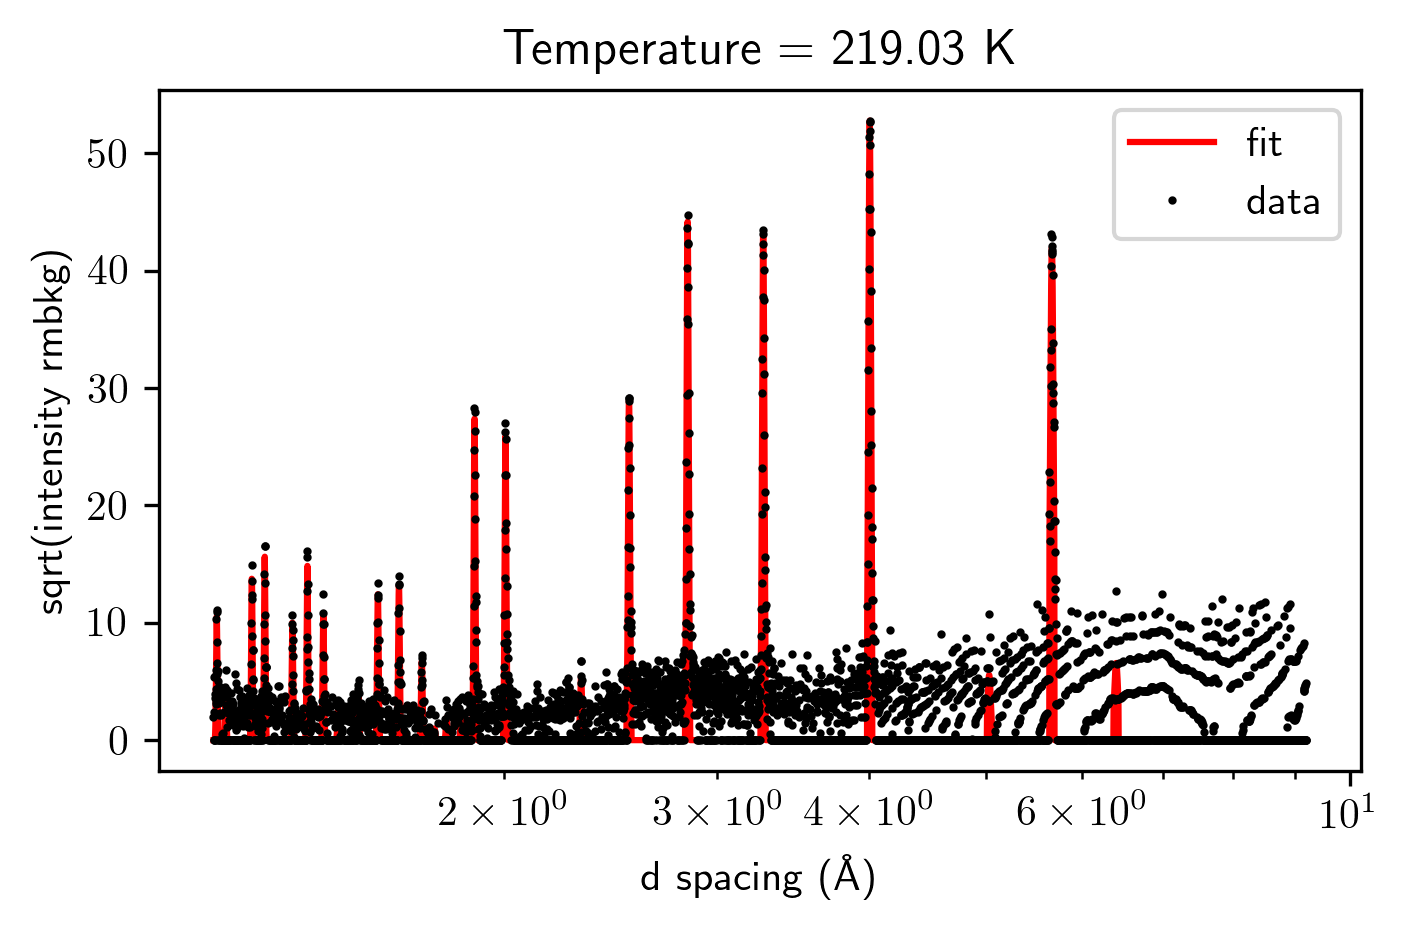

In [11]:
temp=220
parindx = (abs(temps-temp)).argmin()
data = intsy_rmbkg[parindx].flatten()

peakindx = _find_peaks_byindx(data)

par_ini, bounds= Ini_Mpeaks_pars(data, peakindx, dd_cs, Bkg=[])
fit = least_squares(Mpeaks_LS, par_ini, bounds=bounds, 
                    args=(data, peakindx, dd_cs, len([])))
model = Mpeaks_model(fit.x, data, peakindx, dd_cs, len([]))


filename = "Q3/Figs/peakfinding_asyricker_%dK_prerun.png" %(temp)
plt.figure(figsize(4.8, 3.2))
plt.plot(dd_cs, np.sqrt(model), '-', color='red', label='fit')
plt.plot(dd_cs, np.sqrt(data), 'o', color='black', markersize=1,label='data')
plt.ylabel('sqrt(intensity rmbkg)')
plt.xlabel('d spacing (\AA)')
plt.xscale('log')
plt.legend()
_title = 'Temperature = %5.2f K' %(temps[parindx])
plt.title(_title)
plt.tight_layout()
plt.savefig(filename)

### 3.3.2 Second run: clean-up peaktable by peak amplitude after fitting, and save the peaktable.

    Right now, a single criterion is used for the second peak screening. It is better to use differnt criteia for high-d and low-d regions, similar to what we do for peak finding. It is simply due to different noise levels in these two regions. 

number of peaks was reduced from 25 to 17


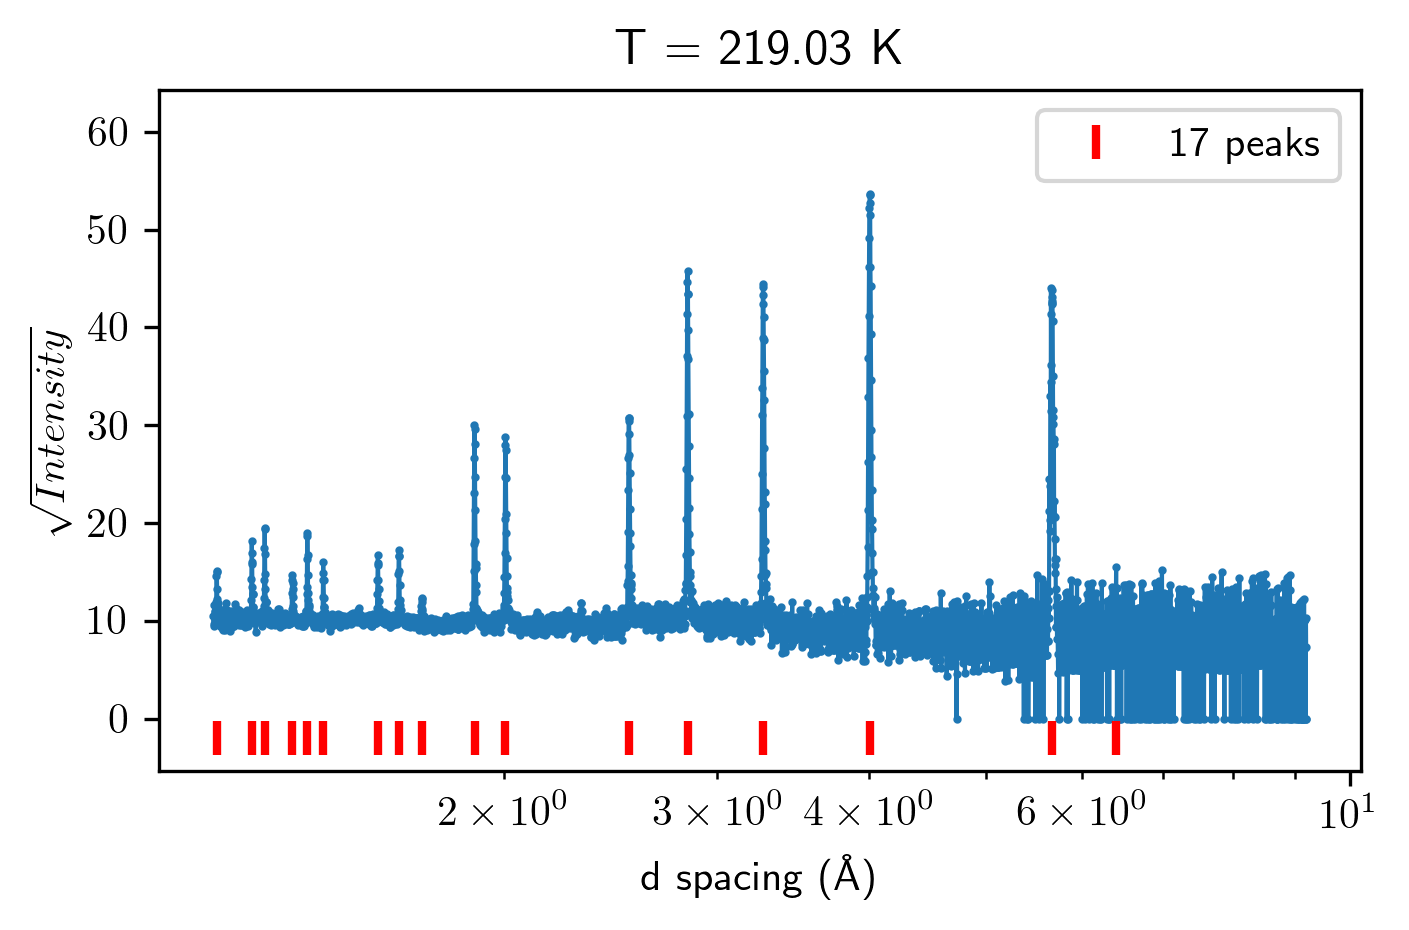

In [12]:
_peaktable = gen_peaktable(fit.x, dds, peakindx, NoBkg=0)
peaktable = _peaktable[_peaktable[:, 1] > bkg.std()*1.5 ]
print( 'number of peaks was reduced from %d to %d' %(_peaktable[:, 0].size, peaktable[:, 0].size) )
filename = "Q3/Data/peaktable_%dK" %(temp)
np.save(filename, peaktable)

plt.figure(figsize(4.8, 3.2))
filename = "Q3/Figs/peakfinding_asyricker_%dK.png" %(temp)
plot_peakloc(intsy, temps, dd_cs, peaktable[:, 0], par_val=temp, 
             outputfilename = filename)

## 3.4 Wrap up. 

In [26]:
def find_peaks_flow(IntsyMap, pars, bin_cs, par_val=0, sep = 1/4, min_dis=2, 
                    wavelet=_ricker_asy, bkg=0):
    '''
    If a non-zero background term (float) is given, then it assumes that background is 
    predetermined and a background-removed dataset is given. the given value will be 
    the cutoff value.
    
    Otherwise it use 50 percentile value as the background limit. A cutoff value will 
    be calcualted. 
    '''
    from scipy.optimize import least_squares
    
    
    data = intsy[ (abs(pars - par_val)).argmin()].flatten()
    peakindx = _find_peaks_byindx(data, sep=sep, min_dis=min_dis, wavelet=wavelet) 
    
    if(bkg != 0):
        Bkg = []
        cutoff = bkg
    else:
        Bkg = [np.percentile(data, 50)]
        cutoff = np.percentile(data, 50) + data[data<np.percentile(data, 50)].std()
    
    par_ini, bounds= Ini_Mpeaks_pars(data, peakindx, bin_cs, Bkg=Bkg)
    fit = least_squares(Mpeaks_LS, par_ini, bounds=bounds, args=(data, peakindx, bin_cs, len(Bkg)))
    model = Mpeaks_model(fit.x, data, peakindx, bin_cs, len(Bkg))
    peaktable = gen_peaktable(fit.x, bin_cs, peakindx, NoBkg=len(Bkg), cutoff=cutoff)
    
    return peaktable


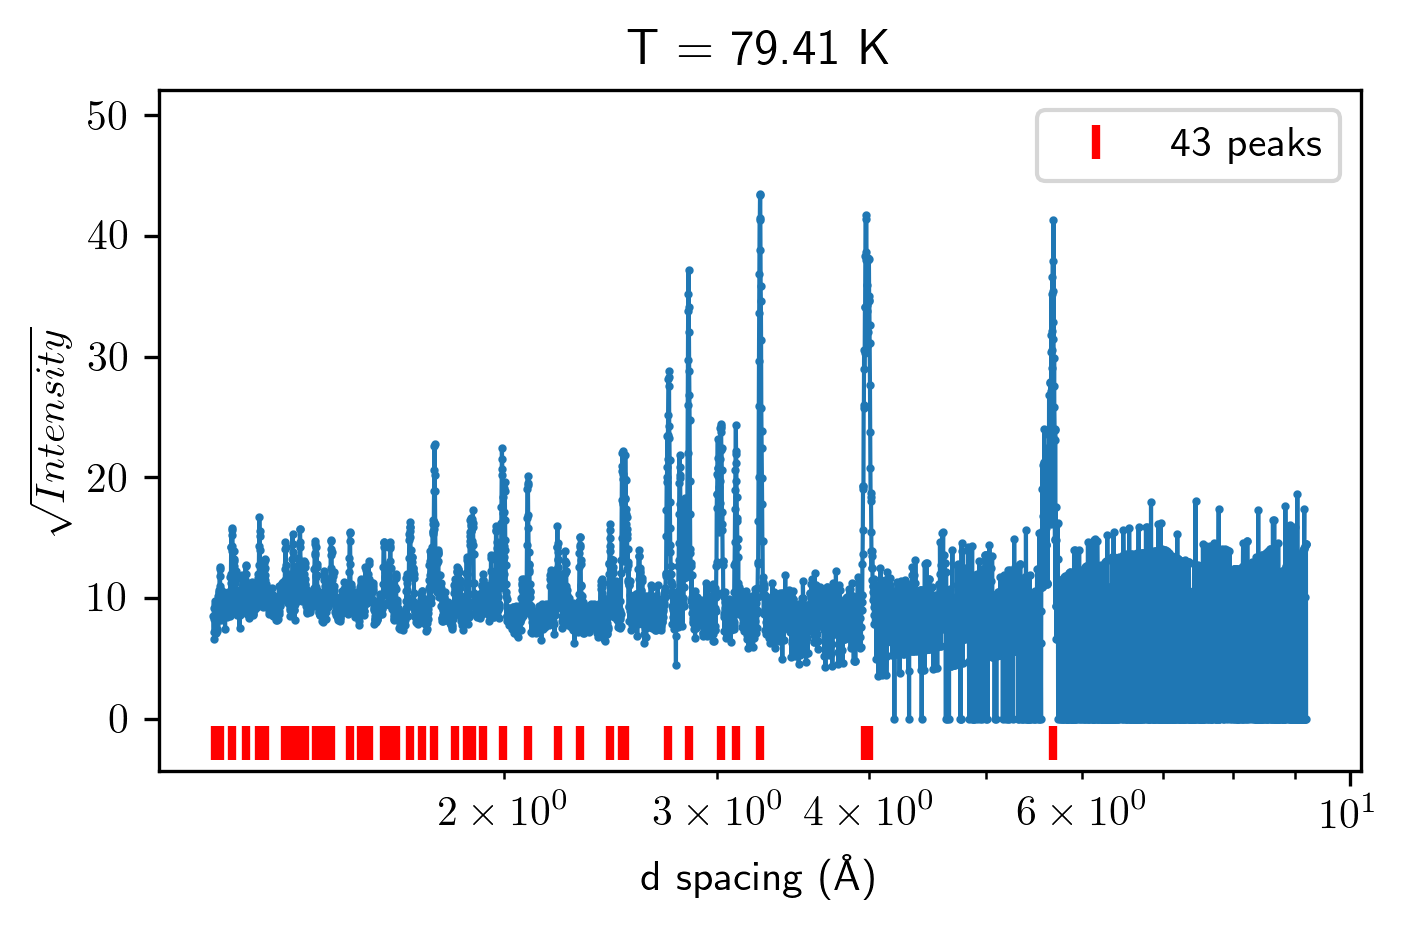

In [32]:
temp=80
peaktable = find_peaks_flow(intsy_rmbkg, temps, dd_cs, par_val=temp, 
                            bkg = bkg.std() * 2.5) 
filename = "Q3/Data/peaktable_%dK" %(temp)
np.save(filename, peaktable)
plt.figure(figsize(4.8, 3.2))
#filename = "Q3/Figs/peakfinding_asyricker_%dK.png" %(temp)
plot_peakloc(intsy, temps, dd_cs, peaktable[:, 0], par_val=temp, 
             outputfilename = filename)

In [22]:
peaktable[0], len(peaktable)

(array([  1.154e+00,   8.581e+01,   4.719e-03,   2.201e+03]), 49)